# Learning curve calculation and plotting.
## Author: Zhi Li
## Date: 04/05/2019
### After removing fixed ratio data points, we now have 4967 reactions to model. Based on the overal data, PUFK_SVM model performs the best. In this script, I will accomplish below task for Methylammonium, Ethylammonium, n-Butylammonium,  Formamidinium, Acetamidinium, Cyclohexylmethylammonium (with all 4 metrics) : 1) PUFK_SVM learning curve with N-1 amine 2) PUFK_SVM learning curve with only target amine 3) 1NN learning curve with only target amine 4) single feature (formic acid, organic, inorganic) learning curve with only target amine.

In [1]:
import os, fnmatch
import numpy as np
import pandas as pd
import pprint
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data input
file = "0042.perovskitedata_RAPID.csv"
df_all = pd.read_csv(file)

Inchi = pd.read_csv("Organic Inchikey.csv")
Inchidict = dict(zip(Inchi['Chemical Name'], Inchi['InChI Key (ID)']))

lst = ["LLWRXQXPJMPHLR-UHFFFAOYSA-N","XFYICZOIWSBQSK-UHFFFAOYSA-N","CALQKRVFTWDYDG-UHFFFAOYSA-N",\
       "QHJPGANWSLEMTI-UHFFFAOYSA-N","GGYGJCFIYJVWIP-UHFFFAOYSA-N","FCTHQYIDLRRROX-UHFFFAOYSA-N",\
       "JMXLWMIFDJCGBV-UHFFFAOYSA-N","PXWSKGXEHZHFJA-UHFFFAOYSA-N","DMFMZFFIQRMJQZ-UHFFFAOYSA-N",\
       "NOHLSFNWSBZSBW-UHFFFAOYSA-N","NLJDBTZLVTWXRG-UHFFFAOYSA-N","LCTUISCIGMWMAT-UHFFFAOYSA-N",\
       "WGYRINYTHSORGH-UHFFFAOYSA-N","VAWHFUNJDMQUSB-UHFFFAOYSA-N","HBPSMMXRESDUSG-UHFFFAOYSA-N",\
       "VNAAUNTYIONOHR-UHFFFAOYSA-N","ZEVRFFCPALTVDN-UHFFFAOYSA-N","NXRUEVJQMBGVAT-UHFFFAOYSA-N",\
       "JERSPYRKVMAEJY-UHFFFAOYSA-N"]
for x in lst:
    df = df.append(df_all[(df_all._rxn_organic_inchikey == x)])

In [3]:
Amine_done = [] # actually it is amine for analysis
for i in df['_rxn_organic_inchikey']:
    if i not in Amine_done: 
        Amine_done.append(i)

for i in range(len(Amine_done)):
    Amine_done[i] = dict(zip(Inchi['InChI Key (ID)'],Inchi['Chemical Name']))[Amine_done[i]]
print (Amine_done)

['n-Butylammonium iodide', 'Ethylammonium Iodide', 'Methylammonium iodide', 'Acetamidinium iodide', 'Formamidinium Iodide']


In [4]:
# Generate input, output and reference dataframe
X = df.drop(['RunID_vial', '_out_crystalscore', '_rxn_organic_inchikey'], axis =1)
y = df.filter(['_out_crystalscore'], axis =1)
inchikey = df.filter(['RunID_vial', '_rxn_organic_inchikey'])

# Standarize the input
x = StandardScaler().fit_transform(X) # dataframe turned into array and it is reformed as dataframe in the below line
X = pd.DataFrame(x, index = X.index, columns = X.columns)

y = (y.replace([1,2,3],0)).replace(4,1) # turned into binary classification

### Function to calculate lmetric of models

In [5]:
def SVM_PUFK_metrics (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid'):
    
    def PearsonVII_kernel(X1,X2, sigma=1.0, omega=1.0):
        if X1 is X2 :
            kernel = squareform(pdist(X1, 'euclidean'))
        else:
            kernel = cdist(X1, X2, 'euclidean')
        kernel = (1 + (kernel * 4 * np.sqrt(2**(1.0/omega)-1)) / sigma**2) ** omega
        kernel = 1/kernel
        return kernel
    
    clf = SVC(C=10,cache_size=6000,max_iter=-1,kernel=PearsonVII_kernel,\
              decision_function_shape='ovr', probability=False, class_weight='balanced')
    X_train = X_train.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    X_test = X_test.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)
    precision = precision_score(y_test,y_predict, pos_label=pos_label) 
    recall = recall_score(y_test,y_predict, pos_label=pos_label)
    f1 = f1_score (y_test,y_predict, pos_label=pos_label) 
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [6]:
def KNN_metrics (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid'):
    clf = KNeighborsClassifier(n_neighbors = 1, weights = "uniform", p = 2)
    X_train = X_train.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    X_test = X_test.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)
    precision = precision_score(y_test,y_predict, pos_label=pos_label) 
    recall = recall_score(y_test,y_predict, pos_label=pos_label)
    f1 = f1_score (y_test,y_predict, pos_label=pos_label) 
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [7]:
# Human prediction: based on the feacture with highest priority
def onefeaturekNN (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid', k=1):
    clf = KNeighborsClassifier(n_neighbors = k, weights = "uniform", p = 2)
    X_train = X_train.filter([feature], axis = 1)
    X_test = X_test.filter([feature], axis = 1)
    clf.fit(X_train,y_train)   
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)                       
    precision = precision_score(y_test,y_predict, pos_label=pos_label)                      
    recall = recall_score(y_test,y_predict, pos_label=pos_label)                  
    f1 = f1_score(y_test,y_predict, pos_label=pos_label)
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [8]:
def train_size (X_ammonium_train, node):
    n = len(X_ammonium_train[0].index)
    split = list(map(lambda x: int(x*n), node))
    return split

In [9]:
# Function to save any obj in 'obj' folder
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as file:
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as file:
        return pickle.load(file)

### Function to calculate learning metric

In [10]:
def learn_score (learn_rate, n_splits,\
                 X_ammonium_train, y_ammonium_train, X_ammonium_test, y_ammonium_test,\
                 X_rest_ammonium = 0, y_rest_ammonium = 0,\
                 f = SVM_PUFK_metrics, metric = 'accuracy', feature = '_rxn_M_acid', rest_ammonium = 0):
    learn_metric = np.zeros((len(learn_rate), n_splits, n_splits))
    for j in range(len(learn_rate)):
        if (learn_rate[j]>0) & (learn_rate[j]<1):
            for i in range(n_splits):               
                score_list = []
                learn_split = StratifiedShuffleSplit(n_splits=n_splits , test_size=1-learn_rate[j], random_state=42)
                for train_index, test_index in learn_split.split(X_ammonium_train[i], y_ammonium_train[i]):
                    if rest_ammonium == 0:
                        score_list.append(f(X_ammonium_train[i].iloc[train_index], y_ammonium_train[i].iloc[train_index],\
                                            X_ammonium_test[i], y_ammonium_test[i], feature = feature)[metric])
                    elif rest_ammonium == 1:
                        score_list.append(f(pd.concat([X_ammonium_train[i].iloc[train_index], X_rest_ammonium]),\
                                            pd.concat([y_ammonium_train[i].iloc[train_index], y_rest_ammonium]),\
                                            X_ammonium_test[i], y_ammonium_test[i])[metric])#stop here
                learn_metric[j][i] = score_list
                print('finished train/test split number: ', (i+1))
        elif learn_rate[j] == 1:
            for i in range(n_splits):
                learn_metric[j][i] = [f(X_ammonium_train[i],y_ammonium_train[i],\
                                        X_ammonium_test[i], y_ammonium_test[i], feature = feature)[metric]]*n_splits
                print('finished train/test split number: ', (i+1))
        else:
            raise IndexError()
        print('finished learning rate: ', learn_rate[j])
        
    if rest_ammonium == 1:
        learn_0 = np.zeros((n_splits, n_splits))
        for i in range(n_splits):
            learn_0[i] = [f(X_rest_ammonium, y_rest_ammonium, X_ammonium_test[i], y_ammonium_test[i])[metric]]*n_splits
        learn_metric = np.insert(learn_metric, obj = [0], values = learn_0, axis = 0)
        print('Added prediction metric with only N-1 ammonium')
    return learn_metric

### Fuction to plot learning curve for different metrics

In [11]:
def learn_plot (learn_1, learn_2, learn_3, learn_4, learn_5,\
                X_ammonium_train, learn_rate, percentage_0_test, \
                name, metrics_list = ['accuracy', 'precision', 'recall', 'f1'], ymin = 0, ymax = 1):
    
    #building x axis (# of trainingsets in target ammonium)
    x_axis = train_size (X_ammonium_train, node = learn_rate)
    y_axis_1_mean = {}
    y_axis_1_std = {}
    y_axis_2_mean = {}
    y_axis_2_std = {}
    y_axis_3_mean = {}
    y_axis_3_std = {}
    y_axis_4_mean = {}
    y_axis_4_std = {}
    y_axis_5_mean = {}
    y_axis_5_std = {}
    
    #Calculation of mean and std for metric curves
    for metric in metrics_list:
        y_axis_1_mean[metric] = []
        y_axis_1_std[metric] = []
        y_axis_2_mean[metric] = []
        y_axis_2_std[metric] = []
        y_axis_3_mean[metric] = []
        y_axis_3_std[metric] = []
        y_axis_4_mean[metric] = []
        y_axis_4_std[metric] = []
        y_axis_5_mean[metric] = []
        y_axis_5_std[metric] = []
        
        for i in range(len(learn_rate)):
            y_axis_1_mean[metric].append(np.mean(learn_1[metric][i].flatten()))
            y_axis_1_std[metric].append(np.std(learn_1[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_2_mean[metric].append(np.mean(learn_2[metric][i].flatten()))
            y_axis_2_std[metric].append(np.std(learn_2[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_3_mean[metric].append(np.mean(learn_3[metric][i].flatten()))
            y_axis_3_std[metric].append(np.std(learn_3[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_4_mean[metric].append(np.mean(learn_4[metric][i].flatten()))
            y_axis_4_std[metric].append(np.std(learn_4[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_5_mean[metric].append(np.mean(learn_5[metric][i].flatten()))
            y_axis_5_std[metric].append(np.std(learn_5[metric][i].flatten()))
        
    # Metrics for random guess
    y_axis_monotone = {'accuracy': [max(percentage_0_test, (1-percentage_0_test))]*(len(learn_rate)), \
                       'precision': [(1-percentage_0_test)]*(len(learn_rate)), \
                       'recall': [1]*(len(learn_rate)), \
                       'f1':[(2*(1-percentage_0_test)/(1+(1-percentage_0_test)))]*(len(learn_rate))}
    
    # Plotting
    for metric in metrics_list:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x_axis, y_axis_1_mean[metric], 'o-', color = "r", label = "PUFK-SVM prediction")
        ax.plot(x_axis, y_axis_2_mean[metric], '^-', color = "green", label = "Formic acid based prediction")
        ax.plot(x_axis, y_axis_3_mean[metric], 's-', color = "blue", label = "Inorganic based prediction")
        ax.plot(x_axis, y_axis_4_mean[metric], 'd-', color = "purple", label = "Organic based prediction")
        ax.plot(x_axis, y_axis_5_mean[metric], 'H-', color='black', label = "kNN prediction")
        ax.plot(x_axis, y_axis_monotone[metric], color = 'black', label = "Majority voting" if metric == 'accuracy' else 'All positive voting', linestyle='dashed')
        

        ax.fill_between (x_axis, np.array(y_axis_1_mean[metric]) - np.array(y_axis_1_std[metric]), \
                         np.array(y_axis_1_mean[metric]) + np.array(y_axis_1_std[metric]), \
                         color="r", alpha = 0.2)
        ax.fill_between (x_axis, np.array(y_axis_5_mean[metric]) - np.array(y_axis_5_std[metric]), \
                         np.array(y_axis_5_mean[metric]) + np.array(y_axis_5_std[metric]), \
                         color="gray", alpha = 0.2)
        ax.fill_between (x_axis, np.array(y_axis_2_mean[metric]) - np.array(y_axis_2_std[metric]), \
                         np.array(y_axis_2_mean[metric]) + np.array(y_axis_2_std[metric]), \
                         color="green", alpha = 0.2)
        ax.fill_between (x_axis, np.array(y_axis_3_mean[metric]) - np.array(y_axis_3_std[metric]), \
                         np.array(y_axis_3_mean[metric]) + np.array(y_axis_3_std[metric]), \
                         color="blue", alpha = 0.1)
        ax.fill_between (x_axis, np.array(y_axis_4_mean[metric]) - np.array(y_axis_4_std[metric]), \
                         np.array(y_axis_4_mean[metric]) + np.array(y_axis_4_std[metric]), \
                         color="purple", alpha = 0.1)\

        
        ax.set_ylim(ymin, ymax)
        ax.legend()          
        ax.set_xlabel('Number of training experiments')
        ax.set_ylabel('Prediction ' + metric)
        ax.set_title('SVM prediction on ' + name)
        plt.savefig('Learning_Curves/Model comparison on '+ name + '_' + metric + '.svg', format = 'svg', transparent=True)

### User input parameters start here

In [12]:
# Train-test splitting options
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits , test_size=0.2, random_state=42)

# Learning rate/step for different model metrics
learn_rate_1 = [0.1,0.33,0.55,0.78,1.0]
learn_rate_2 = [0.02,0.06,0.1,0.33,0.55,0.78,1.0]
learn_rate = [0.02,0.06,0.1,0.33,0.55,0.78,1.0]
metrics_list = ['accuracy', 'precision', 'recall', 'f1']
feature_list = ['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic']

## Learning curve generation

In [13]:
amine_dict = {'Methylammonium iodide':'MAPbI3','Ethylammonium Iodide':'EtAPbI3', 'n-Butylammonium iodide':'nBuA2PbI4',\
               'Formamidinium Iodide':'FAPbI3', 'Acetamidinium iodide':'AcetPbI3'}

In [14]:
ammonium = 'Ethylammonium Iodide'

##Split "unknown" amine and "known" amine

# Find ammonium index in original dataframe
inchi = Inchidict[ammonium]
ammonium_index = inchikey.index[inchikey['_rxn_organic-inchikey'] == inchi].tolist()

# pick target ammonium
X_ammonium = X.filter(ammonium_index, axis = 0)
y_ammonium = y.filter(ammonium_index, axis = 0)

# pick N-1 ammonium
X_rest_ammonium = X.drop(ammonium_index, axis = 0)
y_rest_ammonium = y.drop(ammonium_index, axis = 0)


## Split trainsets and testsets
# Generate train and test list, number of elements (dataframe) is n_splits in Train-test splitting options
X_ammonium_train = []
y_ammonium_train = []
X_ammonium_test = []
y_ammonium_test = []

for train_index, test_index in sss.split(X_ammonium, y_ammonium):
    X_ammonium_train.append(X_ammonium.iloc[train_index])
    y_ammonium_train.append(y_ammonium.iloc[train_index])
    X_ammonium_test.append(X_ammonium.iloc[test_index])
    y_ammonium_test.append(y_ammonium.iloc[test_index])

print(train_size(X_ammonium_train, (learn_rate)))

# percentage of 0 and 1 in y_ammonium_test
percentage_0_test = list(y_ammonium_test[0]['_out_crystalscore']).count(0)\
    /len(y_ammonium_test[0].index)

[11, 35, 59, 196, 327, 464, 595]


In [15]:
percentage_0_test
count_1 = y_ammonium[y_ammonium['_out_crystalscore']==1]
count_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 336 to 1052
Data columns (total 1 columns):
_out_crystalscore    183 non-null int64
dtypes: int64(1)
memory usage: 2.9+ KB


In [16]:
percentage_0_test

0.7516778523489933

### Single feature prediction learning curve generation,  one feature nearest neighbor score

In [51]:
for feature in feature_list:
    learn_ammonium_only_1feature = {}
    for metric in metrics_list:
        learn_ammonium_only_1feature[metric] = learn_score (learn_rate = learn_rate, n_splits=n_splits,\
                                                             X_ammonium_train = X_ammonium_train,\
                                                             y_ammonium_train = y_ammonium_train,\
                                                             X_ammonium_test = X_ammonium_test,\
                                                             y_ammonium_test = y_ammonium_test,\
                                                             X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                             f = onefeaturekNN, feature = feature, metric = metric, rest_ammonium = 0)
        print('finished predicion metric: ', metric)
    print('finished predicion feature: ', feature)
    save_obj(learn_ammonium_only_1feature, 'learn_ammonium_only_1feature_' + ammonium + feature)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
finished predicion feature:  _rxn_M_inorganic
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split nu

### SVM learning curve generation

In [134]:
# With only targe amine
learn_ammonium_only = {}
for metric in metrics_list:
    learn_ammonium_only[metric] = learn_score (learn_rate = learn_rate, n_splits=n_splits,\
                                               X_ammonium_train = X_ammonium_train, \
                                               y_ammonium_train = y_ammonium_train,\
                                               X_ammonium_test = X_ammonium_test, \
                                               y_ammonium_test = y_ammonium_test,\
                                               X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                               f = SVM_PUFK_metrics, feature = feature, metric = metric, rest_ammonium = 0)
    print('finished predicion metric: ', metric)
save_obj(learn_ammonium_only, 'learn_ammonium_only_PUFKSVM_3D_' + ammonium)

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

In [53]:
# With N-1 + target amine
learn_ammonium_rest = {}
for metric in metrics_list:
    learn_ammonium_rest[metric] = learn_score (learn_rate = learn_rate, n_splits=n_splits,\
                                               X_ammonium_train = X_ammonium_train, \
                                               y_ammonium_train = y_ammonium_train,\
                                               X_ammonium_test = X_ammonium_test, \
                                               y_ammonium_test = y_ammonium_test,\
                                               X_rest_ammonium = X_rest_ammonium, y_rest_ammonium = y_rest_ammonium,\
                                               f = SVM_PUFK_metrics, feature = feature, metric = metric, rest_ammonium = 1)
    print('finished predicion metric: ', metric)
save_obj(learn_ammonium_rest, 'learn_ammonium_rest_PUFKSVM_' + ammonium)

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

### kNN learning curve generation

In [135]:
learn_ammonium_only_kNN = {}
for metric in metrics_list:
    learn_ammonium_only_kNN[metric] = learn_score (learn_rate = learn_rate, n_splits=n_splits,\
                                                   X_ammonium_train = X_ammonium_train, \
                                                   y_ammonium_train = y_ammonium_train,\
                                                   X_ammonium_test = X_ammonium_test, \
                                                   y_ammonium_test = y_ammonium_test,\
                                                   X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                   f = KNN_metrics, feature = feature, metric = metric, rest_ammonium = 0)
    print('finished predicion metric: ', metric)
save_obj(learn_ammonium_only_kNN, 'learn_ammonium_only_kNN_3D_' + ammonium)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

###    

## Plotting

#### Plotting Learning Curves for each amine (kNN, onefeaturekNN, SVM)

In [17]:
learn_svm = load_obj('learn_ammonium_only_PUFKSVM_3D_' + ammonium)
learn_svm_rest = load_obj('learn_ammonium_rest_PUFKSVM_' + ammonium)
learn_kNN = load_obj('learn_ammonium_only_kNN_3D_' + ammonium)
learn_acid = load_obj('learn_ammonium_only_1feature_' + ammonium + '_rxn_M_acid')
learn_inorganic = load_obj('learn_ammonium_only_1feature_' + ammonium + '_rxn_M_inorganic')
learn_organic = load_obj('learn_ammonium_only_1feature_' + ammonium + '_rxn_M_organic')

['accuracy', 'precision', 'recall', 'f1']

['accuracy', 'precision', 'recall', 'f1']

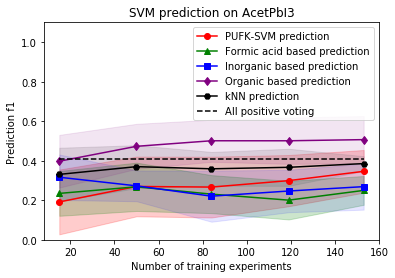

In [210]:
learn_plot (learn_1 = learn_svm, learn_2 = learn_acid, learn_3 = learn_inorganic, \
            learn_4 = learn_organic, learn_5 = learn_kNN,\
            X_ammonium_train = X_ammonium_train, learn_rate = learn_rate, \
            percentage_0_test = percentage_0_test, \
            name = amine_dict[ammonium], metrics_list = ['f1'], ymin = 0.0, ymax = 1.1)

#### N-1 vs 1 prediction comparison

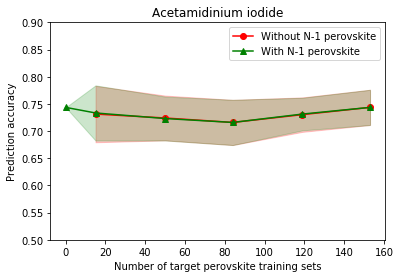

In [241]:
metric = 'accuracy' # the metric we would like to look at

#building x axis (# of trainingsets in target ammonium)
x_axis = train_size(X_ammonium_train, (learn_rate))
x_axis_0 = x_axis.copy()
x_axis_0.insert(0,0)

fig = plt.figure()
ax = fig.add_subplot(111)

y_axis_mean_only = []
y_axis_std_only = []
y_axis_mean_rest = []
y_axis_std_rest = []

for i in range(len(learn_rate)):
    y_axis_mean_only.append(np.mean(learn_svm[metric][i].flatten()))
    y_axis_std_only.append(np.std(learn_svm[metric][i].flatten()))
for i in range(len(learn_rate)+1):
    y_axis_mean_rest.append(np.mean(learn_svm_rest[metric][i].flatten()))
    y_axis_std_rest.append(np.std(learn_svm_rest[metric][i].flatten()))
        
# Plotting
ax.plot (x_axis, y_axis_mean_only, marker = 'o', color = 'red', label = 'Without N-1 perovskite')
ax.plot (x_axis_0, y_axis_mean_rest, marker = '^', color = 'green', label = 'With N-1 perovskite')
ax.fill_between (x_axis, np.array(y_axis_mean_only) - np.array(y_axis_std_only), \
                        np.array(y_axis_mean_only) + np.array(y_axis_std_only), \
                        color = 'red', alpha = 0.2)
ax.fill_between (x_axis_0, np.array(y_axis_mean_rest) - np.array(y_axis_std_rest), \
                        np.array(y_axis_mean_rest) + np.array(y_axis_std_rest), \
                        color = 'green', alpha = 0.2)

ax.set_ylim(0.5,0.9)
ax.legend()          
ax.set_xlabel('Number of target perovskite training sets')
ax.set_ylabel('Prediction ' + metric)
ax.set_title(ammonium)
plt.savefig('Learning_Curves/N vs 1' + '_' + ammonium + '_' + metric + '.svg', format = 'svg', transparent=True)

#### Accuracy prediction for all 5 perovskites

In [127]:
amine_dict

{'Methylammonium iodide': 'MAPbI3',
 'Ethylammonium Iodide': 'EtAPbI3',
 'n-Butylammonium iodide': 'nBuA2PbI4',
 'Formamidinium Iodide': 'FAPbI3',
 'Acetamidinium iodide': 'AcetPbI3'}

In [128]:
learn_svm_list = {}
for key,value in amine_dict.items(): 
    learn_svm_list[value] = load_obj('learn_ammonium_only_PUFKSVM_3D_' + key)

<IPython.core.display.Javascript object>


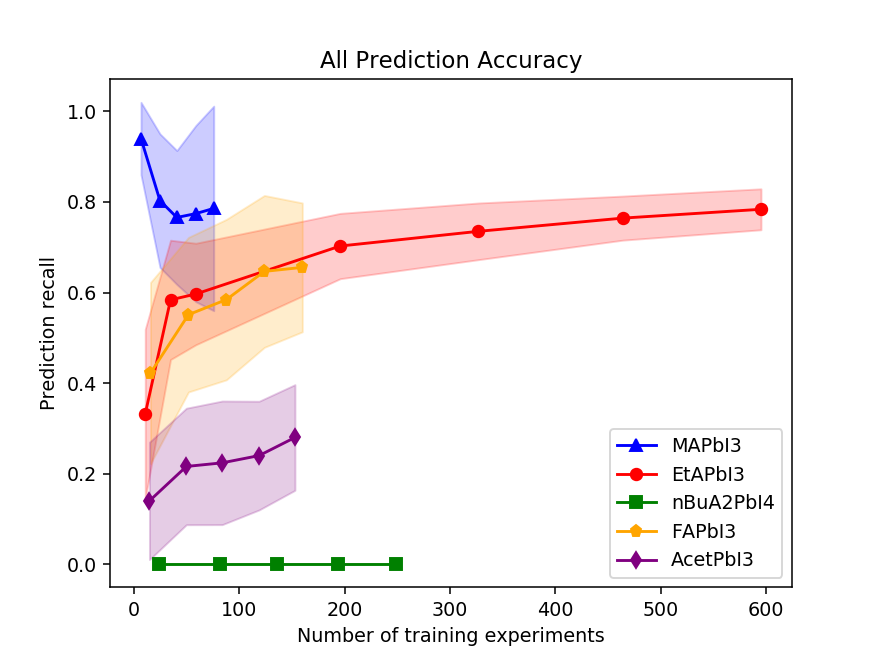

In [130]:
# Training data number for learning curve.
x_MA = [7, 25, 41, 59, 76]
x_EtA = [11, 35, 59, 196, 327, 464, 595]
x_nBuA = [24, 82, 136, 194, 249]
x_FA = [16, 52, 88, 124, 160]
x_Acet = [15, 50, 84, 119, 153]

#building x axis (# of trainingsets in target ammonium)
x_axis = [x_MA, x_EtA, x_nBuA, x_FA, x_Acet]
metric = 'recall'
color_type = ['blue', 'red', 'green','orange', 'purple']
marker_type = ['^', 'o', 's', 'p', 'd']


fig = plt.figure()
ax = fig.add_subplot(111)


for j in range(len(learn_svm_list)):
    y_axis_mean = []
    y_axis_std = []
    if (list(learn_svm_list.keys())[j] == 'EtAPbI3'):
        learn_rate_plot = learn_rate_2
    else:
        learn_rate_plot = learn_rate_1
    for i in range(len(learn_rate_plot)):
        y_axis_mean.append(np.mean(learn_svm_list[list(learn_svm_list.keys())[j]][metric][i].flatten()))
        y_axis_std.append(np.std(learn_svm_list[list(learn_svm_list.keys())[j]][metric][i].flatten()))
        
    # Plotting
    ax.plot (x_axis[j], y_axis_mean, marker = marker_type[j], color = color_type[j], label = list(learn_svm_list.keys())[j])
    ax.fill_between (x_axis[j], np.array(y_axis_mean) - np.array(y_axis_std), \
                         np.array(y_axis_mean) + np.array(y_axis_std), \
                         color = color_type[j], alpha = 0.2)

    #ax.set_xlim(0, len(X_ammonium.index))
    ax.legend()          
    ax.set_xlabel('Number of training experiments')
    ax.set_ylabel('Prediction ' + metric)
    ax.set_title('All Prediction Accuracy')
plt.savefig('Learning_Curves/PUFK_SVM_Prediction_all perovskite' + '_' + metric + '.svg', format = 'svg', transparent=True)

In [252]:
np.mean(learn_svm_list['EtAPbI3']['accuracy'][3].flatten())

0.966984126984127

In [18]:
learn_kNN_EtA = load_obj('learn_ammonium_only_kNN_3D_' + 'Ethylammonium Iodide')

In [19]:
np.mean((learn_kNN_EtA['accuracy'][2]).flatten())

0.822013422818792

In [20]:
np.mean((learn_kNN_EtA['accuracy'][3]).flatten())

0.8381208053691276

In [21]:
0.822013422818792 + ((100-59)/(196-59))*(0.8381208053691276-0.822013422818792)

0.8268338803703522

# Currently not used code

In [39]:
ammonium

'Ethylammonium Iodide'

In [41]:
x_EtA = [11, 35, 59, 196, 327, 464, 595]

<IPython.core.display.Javascript object>


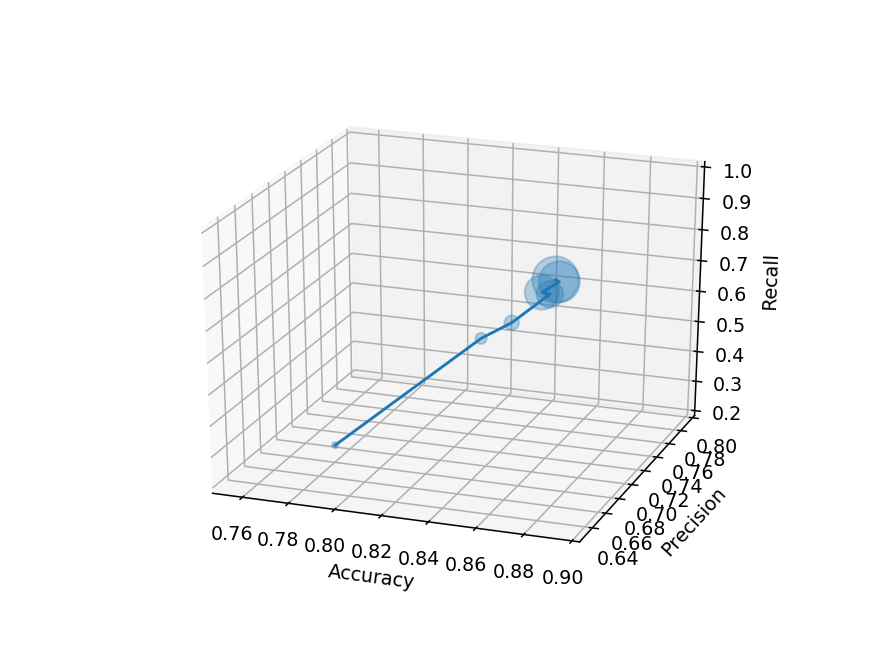

In [83]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
learning_curve = learn_svm.copy()

x_range = [0.75,0.9]
y_range = [0.625,0.8]
z_range = [0.2,1]
xy_plane = z_range[0] - 3
xz_plane = y_range[1] + 0.1
yz_plane = x_range[0] - 0.5
x_step = 0.5
y_step = 1
z_step = 2

x_axis_mean = []
y_axis_mean = []
z_axis_mean = []
x_axis_std = []
y_axis_std = []
z_axis_std = []
for i in range(len(learn_rate)):
    x_axis_mean.append(np.mean(learning_curve['accuracy'][i].flatten()))
    x_axis_std.append(np.std(learning_curve['accuracy'][i].flatten()))
for i in range(len(learn_rate)):
    y_axis_mean.append(np.mean(learning_curve['precision'][i].flatten()))
    y_axis_std.append(np.std(learning_curve['precision'][i].flatten()))
for i in range(len(learn_rate)):
    z_axis_mean.append(np.mean(learning_curve['recall'][i].flatten()))
    z_axis_std.append(np.std(learning_curve['recall'][i].flatten()))

ax.scatter(x_axis_mean, y_axis_mean, z_axis_mean, s = x_EtA, alpha = 0.3)
ax.plot(x_axis_mean, y_axis_mean, z_axis_mean)

"""# 2D projections plot
ax.scatter(x_axis_mean, z_axis_mean, s = x_EtA, zdir = 'y', zs = 0.9, alpha=0.3)
ax.plot(x_axis_mean, z_axis_mean, zdir = 'y', zs = 0.9)
ax.scatter(y_axis_mean, z_axis_mean, s = x_EtA, zdir = 'x', zs = 0.75, alpha=0.3)
ax.plot(y_axis_mean, z_axis_mean, zdir = 'x', zs = 0.75)
ax.scatter(x_axis_mean, y_axis_mean, s = x_EtA, zdir='z', zs = 0.2, alpha=0.3)
ax.plot(x_axis_mean, y_axis_mean, zdir = 'z', zs = 0.2)


# make 2D planes with meshgrid
yy, zz = np.meshgrid(np.arange(y_range[0],y_range[1], y_step), np.arange(z_range[0],z_range[1],z_step))
xx = np.ones((len(np.arange(z_range[0],z_range[1],z_step)), len(np.arange(y_range[0],y_range[1], y_step))))*yz_plane
ax.plot_surface(xx,yy,zz, color = "silver", alpha = 0.1)
ax.plot_wireframe(xx,yy,zz, color = "black", alpha = 0.1)

xx, yy = np.meshgrid(np.arange(x_range[0],x_range[1], x_step), np.arange(y_range[0],y_range[1], y_step))
zz = np.ones((len(np.arange(y_range[0],y_range[1], y_step)), len(np.arange(x_range[0],x_range[1], x_step))))*xy_plane
ax.plot_surface(xx,yy,zz, color = "silver", alpha = 0.1)
ax.plot_wireframe(xx,yy,zz, color = "black", alpha = 0.1)

xx, zz = np.meshgrid(np.arange(x_range[0],x_range[1], x_step), np.arange(z_range[0],z_range[1],z_step))
yy = np.ones((len(np.arange(z_range[0],z_range[1], z_step)), len(np.arange(x_range[0],x_range[1], x_step))))*xz_plane
ax.plot_surface(xx,yy,zz, color = "silver", alpha = 0.1)
ax.plot_wireframe(xx,yy,zz, color = "black", alpha = 0.1)"""


ax.view_init(elev=25, azim=-70)
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_zlim(z_range)

ax.set_xlabel('Accuracy')
ax.set_ylabel('Precision')
ax.set_zlabel('Recall')

plt.savefig('Metrics_learning curve_'+ ammonium + '.svg', format = "svg", transparent=True, dpi = 1000)

In [89]:
learn_svmcopy = learn_svm.copy()

In [94]:
x_svm = []
for i in range(len(learn_rate)):
    x_svm.append(np.mean(learn_svmcopy['accuracy'][i].flatten()))

In [92]:
learn_kNNcopy = learn_kNN.copy()

In [98]:
x_kNN = []
for i in range(len(learn_rate)):
    x_kNN.append(np.mean(learn_kNNcopy['accuracy'][i].flatten()))

In [99]:
x_svm

[0.792751677852349,
 0.8359731543624161,
 0.8426845637583892,
 0.8590604026845639,
 0.8595973154362417,
 0.8655033557046978,
 0.8657718120805369]

In [100]:
x_kNN

[0.7253691275167785,
 0.8018791946308724,
 0.822013422818792,
 0.8381208053691276,
 0.8359731543624161,
 0.8421476510067113,
 0.8389261744966443]

In [103]:
np.array(x_svm) - np.array(x_kNN)

array([0.06738255, 0.03409396, 0.02067114, 0.0209396 , 0.02362416,
       0.0233557 , 0.02684564])

In [105]:
learn_inorganiccopy = learn_inorganic.copy()

In [106]:
x_inorganic = []
for i in range(len(learn_rate)):
    x_inorganic.append(np.mean(learn_inorganiccopy['accuracy'][i].flatten()))

In [107]:
x_inorganic

[0.702013422818792,
 0.7165100671140939,
 0.7208053691275167,
 0.7224161073825504,
 0.7183892617449663,
 0.7111409395973155,
 0.7100671140939597]

In [108]:
np.array(x_svm) - np.array(x_inorganic)

array([0.09073826, 0.11946309, 0.12187919, 0.1366443 , 0.14120805,
       0.15436242, 0.1557047 ])

<IPython.core.display.Javascript object>


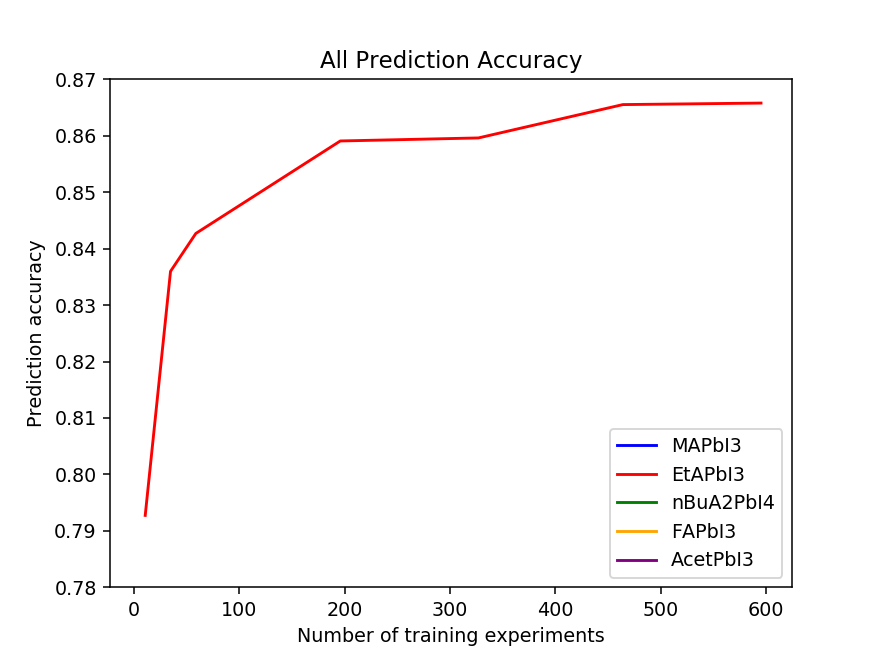

In [140]:
# Training data number for learning curve.
x_MA = [7, 25, 41, 59, 76]
x_EtA = [11, 35, 59, 196, 327, 464, 595]
x_nBuA = [24, 82, 136, 194, 249]
x_FA = [16, 52, 88, 124, 160]
x_Acet = [15, 50, 84, 119, 153]

#building x axis (# of trainingsets in target ammonium)
x_axis = [x_MA, x_EtA, x_nBuA, x_FA, x_Acet]
metric = 'accuracy'
color_type = ['blue', 'red', 'green','orange', 'purple']
marker_type = ['^', 'o', 's', 'p', 'd']


fig = plt.figure()
ax = fig.add_subplot(111)


for j in range(len(learn_svm_list)):
    y_axis_mean = []
    y_axis_std = []
    if (list(learn_svm_list.keys())[j] == 'EtAPbI3'):
        learn_rate_plot = learn_rate_2
    else:
        learn_rate_plot = learn_rate_1
    for i in range(len(learn_rate_plot)):
        y_axis_mean.append(np.mean(learn_svm_list[list(learn_svm_list.keys())[j]][metric][i].flatten()))
        y_axis_std.append(np.std(learn_svm_list[list(learn_svm_list.keys())[j]][metric][i].flatten()))
        
    # Plotting
    ax.plot (x_axis[j], y_axis_mean, color = color_type[j], label = list(learn_svm_list.keys())[j])
    """ax.fill_between (x_axis[j], np.array(y_axis_mean) - np.array(y_axis_std), \
                         np.array(y_axis_mean) + np.array(y_axis_std), \
                         color = color_type[j], alpha = 0.2)"""

    #ax.set_xlim(0, len(X_ammonium.index))
    ax.set_ylim(0.78,0.87)
    ax.legend()          
    ax.set_xlabel('Number of training experiments')
    ax.set_ylabel('Prediction ' + metric)
    ax.set_title('All Prediction Accuracy')
plt.savefig('Learning_Curves/PUFK_SVM_Prediction_all perovskite' + '_' + metric + '_TOC.svg', format = 'svg', transparent=True)